In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [49]:
from simulation.gen_pend import *

param_dists = {
    'q': stats.uniform(-np.pi, 2 * np.pi),  # U[-pi, pi]
    'v': stats.norm(loc=5.),  # U[-3, 3]
    'b': stats.uniform(0., .1) # U[0, .1]
}

times, trajs = gen_trajs(10_000, 2., 20, param_dists)

In [50]:
trajs.shape

(10000, 2, 20)

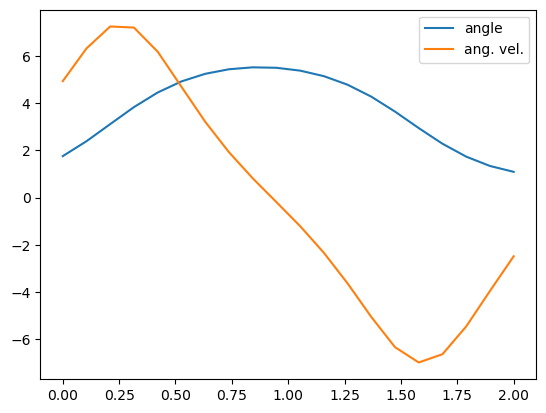

In [51]:
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

Since Pinocchio doesn't give the angles mod 2pi, the angular measurements could get very large. We'll stick to short time-frames so that this doesn't become a problem.

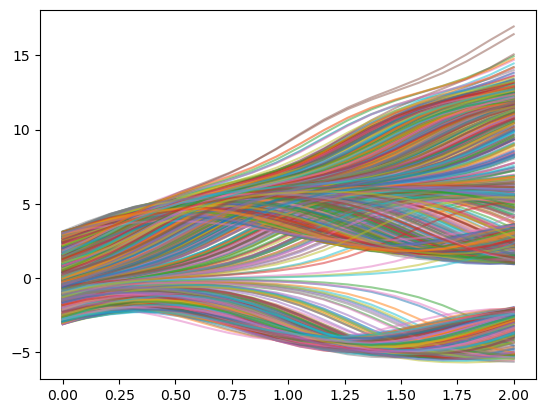

In [52]:
for i in range(1000):
    plt.plot(times, trajs[i, 0], alpha=.5)

## Splitting the trajectories into windows

We'll split the trajectories into windows - that way, the MLP architecture won't depend on the length of trajectories to which we apply it.

In [29]:
class TrajWindowsDataset(Dataset):
    def __init__(self, trajs, window):
        super().__init__()
        self.window = window
        self.n_simulations, _, self.n_steps = trajs.shape
        assert window <= self.n_steps
        self.windows_per_traj = self.n_steps - self.window + 1

    def __len__(self):
        return self.n_simulations * self.windows_per_traj

    def __getitem__(self, idx):
        i = idx // self.windows_per_traj
        j = idx % self.windows_per_traj
        return trajs[i, :, j:(j+self.window)]

In [358]:
window = 20
X = TrajWindowsDataset(trajs, window)
dl = DataLoader(X, batch_size=256, shuffle=True)

## MLP

In [35]:
X_tr, X_val = random_split(torch.tensor(trajs), (30_000, 20_000))
dl_tr = DataLoader(X_tr, batch_size=256, shuffle=True)
dl_val = DataLoader(X_val, batch_size=256, shuffle=True)

In [37]:
class TrajEnc(nn.Module):

    def __init__(self, window, n_features, latent_dim):
        super(TrajEnc, self).__init__()

        self.window = window
        self.n_features = n_features

        self.enc = nn.Sequential(
            nn.Linear(window * n_features, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, window * n_features),
        )

    def forward(self, x):
        # x: (bs, n_features, window)
        x = torch.flatten(x, start_dim=1) # x: (bs, n_features * window)
        u = self.enc(x)
        rec = torch.unflatten(self.dec(u), dim=1, sizes=(self.n_features, self.window))
        return rec, u

In [38]:
te = TrajEnc(20, 2, 2)

opt = optim.Adam(te.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in te.parameters())}')

# params: 2050


In [ ]:
n_epochs = 500

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # --- Training ---
    te.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dl_tr):
        opt.zero_grad()
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        loss.backward()
        opt.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(dl_tr.dataset)
    train_losses.append(train_loss)

    # --- Validation ---
    te.eval()
    val_loss = 0.0

    for batch_idx, x in enumerate(dl_val):
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(dl_val.dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Tr Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

Epoch [10/500], Tr Loss: 105.3767 Val Loss: 67.5673
Epoch [20/500], Tr Loss: 78.7203 Val Loss: 52.0466
Epoch [30/500], Tr Loss: 45.0782 Val Loss: 29.0256
Epoch [40/500], Tr Loss: 24.7582 Val Loss: 16.3571
Epoch [50/500], Tr Loss: 18.3464 Val Loss: 11.9309
Epoch [60/500], Tr Loss: 14.6451 Val Loss: 9.7323
Epoch [70/500], Tr Loss: 12.2221 Val Loss: 7.9981
Epoch [80/500], Tr Loss: 10.4583 Val Loss: 7.0297
Epoch [90/500], Tr Loss: 9.0612 Val Loss: 6.1390
Epoch [100/500], Tr Loss: 8.2421 Val Loss: 5.6624
Epoch [110/500], Tr Loss: 7.8737 Val Loss: 5.3135
Epoch [120/500], Tr Loss: 7.6456 Val Loss: 5.0234
Epoch [130/500], Tr Loss: 7.2315 Val Loss: 4.8044
Epoch [140/500], Tr Loss: 7.1278 Val Loss: 4.7870
Epoch [150/500], Tr Loss: 6.9483 Val Loss: 4.7742
Epoch [160/500], Tr Loss: 6.8223 Val Loss: 4.6386
Epoch [170/500], Tr Loss: 6.6288 Val Loss: 4.7546
Epoch [180/500], Tr Loss: 6.5378 Val Loss: 4.4722
Epoch [190/500], Tr Loss: 6.4100 Val Loss: 4.3928
Epoch [200/500], Tr Loss: 6.3297 Val Loss: 4.

In [59]:
PATH = './mlp_state_dict.pth'
torch.save(te.state_dict(), PATH)

In [39]:
PATH = './mlp_state_dict.pth'
te.load_state_dict(torch.load(PATH))

<All keys matched successfully>

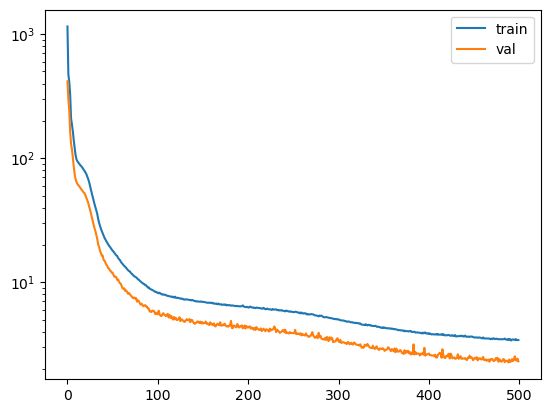

In [60]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.legend()

In [53]:
with torch.no_grad():
    _, latents = te(torch.tensor(trajs))

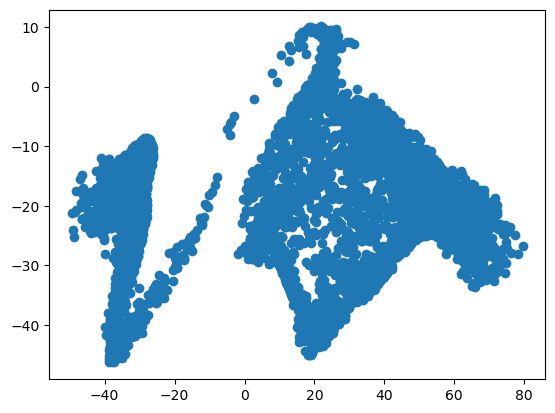

In [54]:
plt.scatter(*latents.T)

In [63]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(times, trajs[idx, 0, :], alpha=.3)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_11380/4048237539.py:3: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



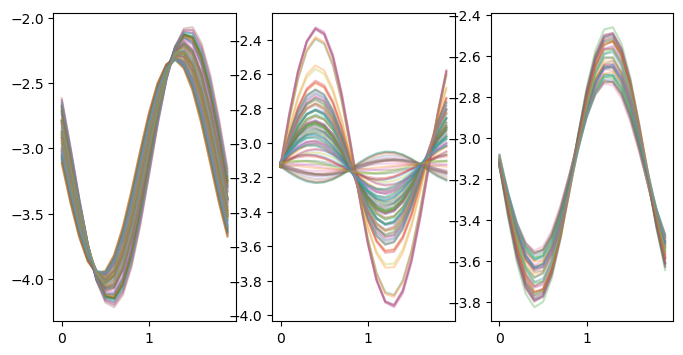

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
plot_most_similar(latents, np.array([-120, 30]), 100, axs[0])
plot_most_similar(latents, np.array([-40, 30]), 100, axs[1])
plot_most_similar(latents, np.array([-60, 0]), 50, axs[2])

In [46]:
from latent_app import create_dash_app

In [65]:
app = create_dash_app(latents.numpy()[::2], trajs[::2, 0])
app.run()

## Testing trajectories outside of the training distribution

In [66]:
_, traj_ood = gen_one_traj(2., .1, np.pi/4, 10., 1.)

with torch.no_grad():
    _, latents_ood = te(torch.tensor(traj_ood))
latents_ood

tensor([[ 18.5946, -28.1380]])

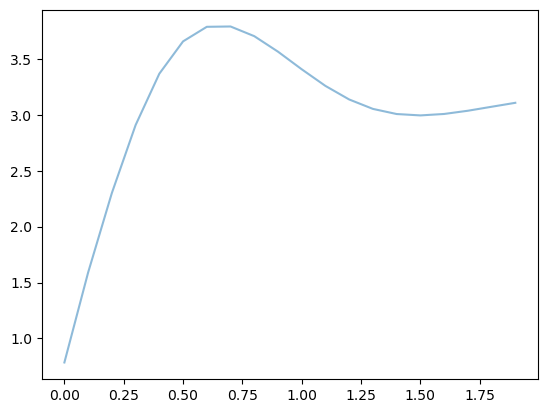

In [67]:
plt.plot(times, traj_ood[0, 0], alpha=.5)

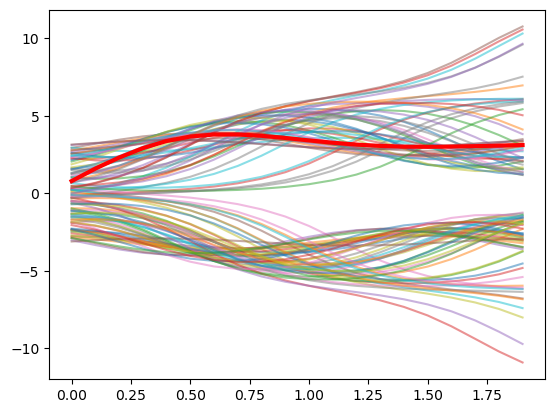

In [68]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, traj_ood[0, 0], color='red', lw=3)

## Using CD poly

In [69]:
from cd_poly.cd_poly import *

In [70]:
p = CDPolynomial(latents, degree=7)
alpha = 1.01 * p(latents).max()

In [71]:
alpha

np.float64(1161.5109956863523)

Note: a cutoff significantly less than the max value on the datapoints seems better at capturing the shape of the support.

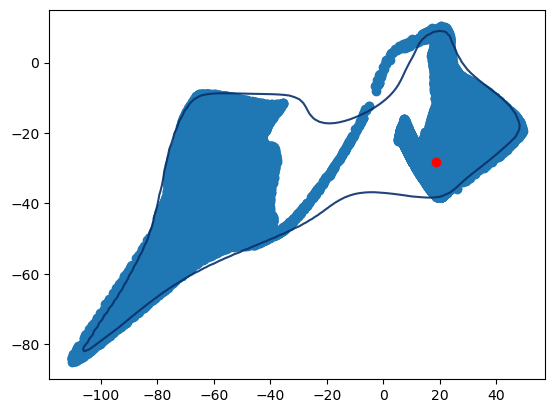

In [72]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_ood.T, color='red')
plot_level_set(p, alpha / 5, ax)

## Testing custom trajectories

Let's create a custom trajectory that couldn't be generated by the simulation with our distribution of parameters.

In [73]:
amp = 1.5
freq = 13.
const = 4
custom = np.array([amp * np.sin(freq * times) + const * times, amp * freq * np.cos(freq * times) + const])

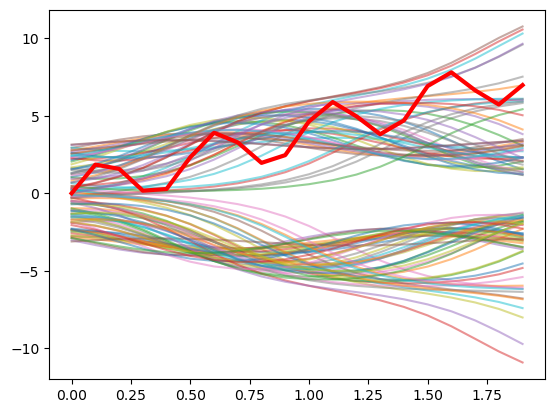

In [74]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, custom[0], color='red', lw=3)

In [75]:
with torch.no_grad():
    _, latents_custom = te(torch.tensor(custom.reshape(1, 2, -1)))
latents_custom

tensor([[42.5700, -4.2711]])

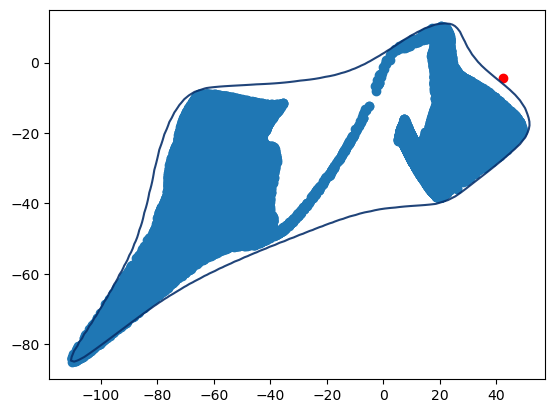

In [76]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_custom.T, color='red')
plot_level_set(p, alpha, ax)